## Instructions {-}

1. This is the template you may use to submit your code and report for the prediction problems on Kaggle.

2. You may modify the template if you deem fit, but it should have the information asked below.

## A.1) Data cleaning

Mention the data cleaning steps taken to prepare your data for developing the model. This may include imputing missing values, dealing with outliers, combining levels of categorical variable(s), etc.

- Imputing missing values:
    - I imputed missing values with a KNNImputer using n_neighbors=8.
    
- Scaling values:
    - I scaled my data using a Standard Scaler.

- Identifying and discarding predictors *(Total number of predictors finally selected to develop model: 26)*:
  - I dropped columns that consisted of the same value for every instance.
  - I dropped duplicate columns.

In [1]:
# Put your data preparation code with comments here
# The code should begin from reading the train data
# The code should end when you obtain the data used to develop the model(s) in (3)

# Import libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from pyearth import Earth
import random
import itertools

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix

from sklearn import impute
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Split data into X and y
y_train = train.y
X_train = train.drop(['id', 'y'], axis=1) 
X_test = test.drop('id', axis=1)

# Take log of y due to skew for later prediction
y_train_log = np.log(y_train)

# Impute with KNNImputer using k=8
imputer = impute.KNNImputer(n_neighbors=8, weights="uniform")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test) 

# Turn back into pandas df
X_train_imputed = pd.DataFrame(X_train_imputed) 
X_train_imputed.columns = X_train.columns
X_test_imputed = pd.DataFrame(X_test_imputed)
X_test_imputed.columns=X_test.columns

# Scale with Standard Scaler
scaler = StandardScaler().fit(X_train_imputed)
X_train_scaled = scaler.transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Turn back into pandas df
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns=X_test.columns

# Find meaningless cols (with all the same value)
same_val_cols = [col for col in X_train_scaled.columns if X_train_scaled[col].nunique() == 1]

# Drop meaningless cols
X_train_scaled.drop(same_val_cols, axis=1, inplace=True)
X_test_scaled.drop(same_val_cols, axis=1, inplace=True)

# Drop duplicate cols from train & test
X_train_scaled = X_train_scaled.T.drop_duplicates().T
X_test_scaled = X_test_scaled.T.drop_duplicates().T

## A.2) Exploratory data analysis

Mention any major insights you obtained from the data, which you used to develop the model. Please put your code or visualizations here if needed.

1. There are 765 anonymized predictors in the dataset, which informed me that feature selection/dimensionality reduction would be necessary.
2. 473 features have missing values, with some features having as much as 16% values missing. 
3. From a .describe(), I found that there were a wide range of magnitudes across the columns.
4. 11 columns only had 1 unique value. 
5. There are also duplicate columns.
6. VIF data demonstrated high multicollinearity.
7. A correlation matrix demonstrated high pairwise correlations.
8. The target variable has a significant right skew.

**None of the below code needs to be run to produce the regression predictions. This code is for EDA purposes only!**

In [7]:
# Insight 1 - Number of predictors
print(X_train.shape)

# Insight 2 - Missing Values
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
missing_values_table(train).head(10)

(5380, 765)
Your selected dataframe has 767 columns.
There are 473 columns that have missing values.


,Missing Values,% of Total Values
x147,863,16.0
x748,863,16.0
x090,763,14.2
x641,763,14.2
x597,759,14.1
x701,759,14.1
x273,741,13.8
x738,741,13.8
x399,707,13.1
x677,707,13.1


In [8]:
# Insight 3 - .describe()
X_train.describe()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
count,5.370000e+03,5380.000000,5377.000000,5380.000000,5.370000e+03,5380.000000,5.377000e+03,5.377000e+03,5.327000e+03,5.380000e+03,...,5378.000000,5380.000000,5.380000e+03,5375.000000,5327.000000,5380.000000,5327.000000,5380.000000,5377.000000,5005.000000
mean,4.623269e+10,14205.468080,6.412851,0.003794,2.978719e+09,0.257727,4.663239e+06,1.968919e+06,2.993064e+05,1.402639e+17,...,0.363471,0.028403,1.031942e+13,0.337180,91.147175,1.931784,49.840248,11.524413,92.241702,0.947097
std,5.214063e+10,11869.274255,0.818170,0.012201,1.860480e+09,0.178621,7.584579e+06,1.690079e+06,1.020525e+06,5.513045e+17,...,0.418773,0.118124,2.626909e+13,0.283159,304.977636,2.379576,170.597793,13.131103,92.728317,4.060325
min,1.135681e+09,3.800000,1.000000,0.000000,5.645178e+08,0.000000,4.945000e+02,1.000000e+00,1.000000e+00,8.779690e+05,...,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.990000
25%,1.105853e+10,5226.627500,5.930000,0.000300,1.547443e+09,0.000000,4.861619e+05,6.638580e+05,8.189500e+03,6.930000e+13,...,0.080000,0.000200,2.913046e+09,0.070000,3.000000,0.000000,2.000000,3.364125,20.720000,-0.620000
50%,2.767335e+10,11152.340000,6.360000,0.000900,2.138110e+09,0.310000,1.736036e+06,1.514608e+06,3.631900e+04,2.110000e+15,...,0.234300,0.001000,4.210000e+11,0.270000,12.000000,1.000000,6.000000,6.742150,59.970000,-0.180000
75%,6.266054e+10,19231.150000,6.860000,0.002700,4.460250e+09,0.400000,6.082900e+06,2.881438e+06,1.271430e+05,4.402500e+16,...,0.499175,0.004400,9.265000e+12,0.550000,37.000000,3.000000,18.000000,14.204225,135.830000,0.670000
max,4.950000e+11,56364.780000,11.000000,0.342000,9.848333e+09,0.500000,6.763421e+07,7.936897e+06,8.411828e+06,7.190000e+18,...,5.570700,1.000000,2.000000e+14,1.000000,2106.000000,24.000000,1165.000000,110.527800,421.200000,53.820000


In [12]:
# Insight 4 - meaningless columns
(X_train.nunique() == 1).value_counts()

False    754
True      11
dtype: int64

In [15]:
# Insight 5 - duplicate columns

# Transpose the DataFrame
df_transposed = X_train.transpose()

# Check for duplicate columns
duplicates = df_transposed.duplicated()

# Print the # of duplicate columns
duplicate_columns = df_transposed[duplicates].index
print(len(duplicate_columns))

92


In [18]:
# Insight 6 - VIF
X_train_vif = X_train_scaled.copy()

X_train_vif = add_constant(X_train_vif)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_vif.columns

for i in range(len(X_train_vif.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X_train_vif.values, i)
    
vif_data.sort_values(by='VIF', ascending=False)[0:5]

,feature,VIF
611,x696,inf
636,x725,inf
287,x312,inf
357,x393,inf
131,x138,inf


In [22]:
# Insight 7 - pairwise correlations
corr_matrix = X_train.corr()

# Find the highly correlated features
threshold = 0.99
high_corr_pairs = np.where(corr_matrix > threshold)

Text(0.5, 1.0, 'Loss Distribution')

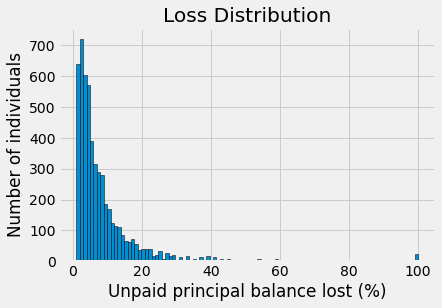

In [23]:
# Insight 8 - distribution of target var
figsize=(8, 8)

# Histogram of the loss
plt.style.use('fivethirtyeight')
plt.hist(train['y'], bins = 100, edgecolor = 'k')
plt.xlabel('Unpaid principal balance lost (%)') 
plt.ylabel('Number of individuals');
plt.title('Loss Distribution')

## A.3) Feature selection/reduction

Mention the steps for feature selection/reduction. Please put your code or visualizations here if needed.

- I developed a MARS model with optimal degree 1 to conduct feature selection.
    - I found optimal degree 1 by looping through MARS models with degrees 1 through 5 and finding the model that returned the best negative mean squared error (my scoring metric).
- I dropped all the predictors that had feature importances of 0.  
- I developed my final model in A.4 based on the remaining 26 predictors.

In [3]:
# Develop a MARS model for feature selection
mars_model = Earth(max_terms=1000, feature_importance_type='rss', max_degree=1)
mars_model.fit(X_train_scaled, y_train)

# Get the feature importances from the MARS model
importances = mars_model.feature_importances_

# Get the indices of features with importances > 0
idx = list(np.where(importances != 0)[0])

# Filter the datasets for the important features
X_train_mars = X_train_scaled.iloc[:, idx]
X_test_mars = X_test_scaled.iloc[:, idx]

## A.4) Developing the model

Mention the logical sequence of steps taken to obtain the final model. 

- Model 1: CatBoostRegressor
    - I developed a CatBoostRegressor model using default inputs.
- Model 2: Bagged CatBoostRegressor
    - I bagged Model 1 using n_estimaors=20 (Code is in Part 4).

In [4]:
# CatBoostRegressor
model_cat = CatBoostRegressor(verbose = False).fit(X_train_mars, y_train_log)

In [5]:
# Use a bagged CatRegressor model
bagged_model = BaggingRegressor(base_estimator=model_cat, 
                                n_estimators=20, 
                                random_state=1,
                                n_jobs=-1).fit(X_train_mars, y_train_log)

# Make predictions using bagged model
y_pred = np.exp(bagged_model.predict(X_train_mars))
intercept = np.mean(y_train-y_pred)
final_pred = np.exp(bagged_model.predict(X_test_mars))+intercept

# Create predictions df
predictions = pd.DataFrame({"id":test.iloc[:, 0], "y":final_pred})

# Clip the predicted y-values in case they are out of range
predictions['y'] = predictions['y'].clip(lower=1, upper=100)

# Export the predictions as a csv file for Kaggle submission
predictions.to_csv("regression_preds.csv", index=False)

## A.5) Discussion

Please provide details of the models/approaches you attempted but encountered challenges or unfavorable outcomes. If feasible, kindly explain the reasons behind their ineffectiveness or lack of success. Additionally, highlight the significant challenges or issues you encountered during the process.

- MARS
    - I started with a MARS model. I tuned for the number of degrees and obtained a degree of 1. Just using this model (with the data preprocessing from above) gave me a naive RMSE of about 9.37, which I thought was decent.
    - My biggest challenge with using a MARS model and tuning the number of degrees was the computational runtime.
    
- Bagged MARS
    - I bagged the above MARS model with 50 estimators which reduced my variance and thus reduced my RMSE to about 9.1. I thought this was a good start, as my peers had presented more complicated techniques that had similar RMSEs. This was also what motivated my usage of MARS for feature importances.
    - I hadn't dropped any features beyond the meaningless and duplicate columns, so I knew I would have to do dimensionality reduction to improve my model below the 8.75 threshold.
    
- Random Forest, Lasso, XGBoostRegressor
    - At points during my process I also used the above models based on my peers' EDA presentations as well as my own knowedge. To tune these models, I used GridSearchCV. However, I also encountered issues with runtime and figuring out how to do feature selection in conjunction with these models. I could have tested out using these models further, but found that CatBoostRegressor was the best.

- CatBoostRegressor
    - This was the model that produced the best RMSE by far. I used the predictors from MARS feature selection with this regressor. It had a low runtime and produced the best RMSE. I used BaggingRegressor to ensemble 20 CatBoostRegressors to get my final predictions and leaderboard RMSE.

## A.6) Conclusion

* Do you feel that you gain valuable experience, skills, and/or knowledge? If yes, please explain what they were. If no, please explain.
    - Yes. I was challenged with the abundance of features as well as how they were all anonymized. This made it so that I had to do more EDA and data preparation to arrive at my final dataset of predictors. I feel that my EDA skills were improved as a result.
    - I learned how to conduct dimensionality reduction and consider multiple methods for feature selection. Initially, I had tried doing PCA, but I found that wasn't as effective for my final RMSE as using MARS model feature importances.
    - I also learned about different types of machine learning models. Throughout my process, I tried out different regressors such as Lasso, MARS, XGBoost, and CatBoostRegressor as well as different ensembling methods.
    - I learned how to keep a clean code file with meaningful comments.
    - I learned how to present my work in a presentation and report format.


* What are things you liked/disliked about the project and/or work on the project?
    - I liked that the project was a prediction problem with a clear goal (to produce a low RMSE), just because our MCMF project did not have clear guidelines and it was difficult to do machine learning with the MCMF dataset. 
    - That being said, it was difficult to juggle doing both the Kaggle prediction problem and the MCMF project at the same time. Having the EDA presentations for both projects on the same day was stressful. 
    - It also seemed counterintuitive to do the Kaggle EDA presentations when everyone obtained similar EDA insights.

## Please make sure your github repo has all the code and  ensure that your code is capable of reproducing the outcomes you have submitted. It is important to avoid any form of academic misconduct or cheating by using your peer's submission file
Note: all my code is also contained within this report.